In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [3]:
import switch_detection_sweep_penalty_one_session as sdspos

In [4]:
row = subdb.iloc[1]
data_dir_full = row['data_dir_full']
ani,sess = row['animal_name.1'],row['sess_name']

In [44]:
subdb.loc[subdb['data_dir_full']==data_dir_full][['animal_name.1','sess_name']].values[0]

array(['e15_13f1', 'e15_13f1_220117'], dtype=object)

In [5]:
pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

all_fields_one_sess=pf_res_recombine['all_fields_recombined']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---


In [6]:
sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
pval = sw_res['pval']
best_n = sw_res['best_n']
X_pwc = sw_res['X_pwc']
X_raw = sw_res['X_raw']
sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
if sw_info_res is None:
    sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
all_sw_with_metrics = sw_info_res['all_sw_with_metrics_d']
fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
fr_map_trial_df_pyr_combined = fr_map_all['fr_map_trial_df_pyr_combined']
fr_map_trial_df_int_combined = fr_map_all['fr_map_trial_df_int_combined']

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---


In [7]:
res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
if res is not None:
    spk_beh_df = res['spk_beh_df']
    cell_cols_d = res['cell_cols_d']
    trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
    index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

In [8]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [9]:
import peer_prediction as pp
reload(pp)

mean_within_field_pred_all,glm_res_df_all,r2_all = pp.sweep_fit_glm_predict_rate_change(spk_beh_df,all_sw_with_metrics,all_fields_one_sess,
                                    index_within_to_trial_index_df,
                                    fr_map_trial_df_int_combined,
                                    cell_cols_d,                                        
                                    do_inh_only=True,
                                    do_weighted_pred=False,
                                    pval_thresh=None,
                                    ti=0)

reload(pp)
per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]
all_sw_with_metrics_oneti_with_inh_change= pp.add_inh_fr_change_to_all_sw(all_sw_with_metrics,mean_within_field_pred_all,per_field_metrics_one,ti=0)





/tmp/ipykernel_1832616/1340198791.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


In [68]:
sw = 1
all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==@sw')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# all_sw_with_metrics_oneti_with_inh_change_onesw.loc[inds].query('inh_fr_change<0')

ii=7
data_sub=all_sw_with_metrics_oneti_with_inh_change_onesw.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False)
row=data_sub.iloc[ii]
tt,uid,field_id = row[['trialtype','uid','field_index']]
r2 = r2_all.loc[tt,uid,field_id]
print(r2)

0.01872534423046257


In [80]:
np.concatenate([np.array([1,2,3]),[np.nan]*2])

array([ 1.,  2.,  3., nan, nan])

(<Figure size 576x864 with 5 Axes>,
 array([<Axes: >,
        <Axes: title={'center': 'cell 42 field 2'}, xlabel='Trial', ylabel='Mean selected Int. FR'>,
        <Axes: xlabel='Trial', ylabel='Mean Int. FR'>], dtype=object))

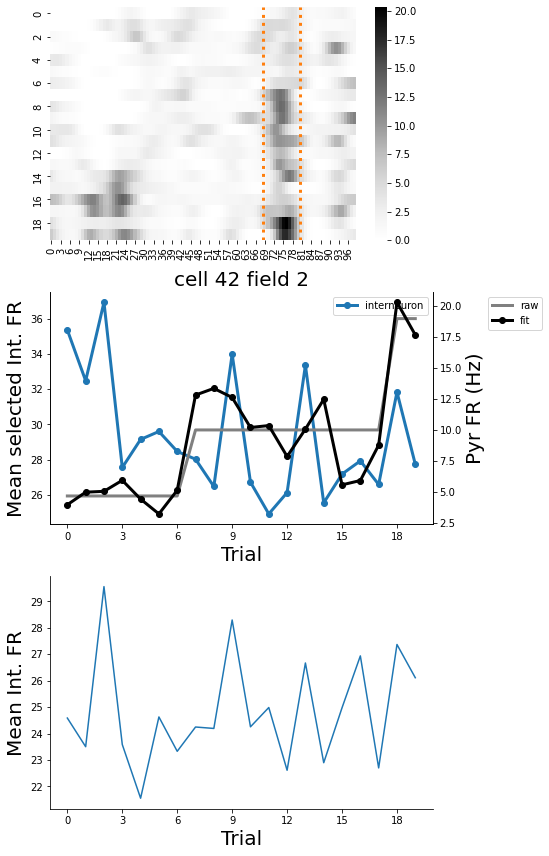

In [69]:
reload(pp)
ti=0
fr_map_one_tt_predictor = fr_map_trial_df_int_combined.loc[(ti,tt)]

fr_map_trial_df_all_for_plot=fr_map_trial_df_pyr_combined

mean_within_field_pred = mean_within_field_pred_all.loc[tt,uid,field_id]
all_fields = all_fields_one_sess
do_weighted_pred=False
reload(pp)
pp.post_fit_plot(mean_within_field_pred,
            all_fields,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred
            )

In [13]:
cell_cols_d

{'pyr': array([ 31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
         42.,  43.,  44.,  54.,  55.,  56.,  57.,  59.,  60.,  61.,  62.,
         63.,  64.,  65.,  66.,  67.,  68.,  70.,  71.,  72.,  73.,  74.,
         75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
         86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
         97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
        131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
        142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
        153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
        164., 165., 166., 167., 168., 169., 170., 171., 172., 173., 174.,
        175., 176., 177., 178., 179., 180., 181., 182., 183., 184., 185.,
        186., 187., 188., 189.,

In [18]:
ti=0
tt=0
uid=31
field_id=1

In [17]:
all_fields_one_sess

start end com peak    fr_peak   fr_mean  \
           field_index                                           
0 0.0  31  1              66  81  73   75   8.654095  6.579647   
       32  1              42  49  45   45   6.259728  4.458995   
       34  0              47  55  50   50   4.316938   3.87356   
       35  1              48  52  49   50   3.301376  3.221881   
       36  0              49  62  55   55   6.541953  4.731811   
...                      ...  ..  ..  ...        ...       ...   
  both 363 0              11  29  18   16   4.996368  2.918468   
       368 0               3  10   6    7   4.144261   3.38993   
       370 0               0   7   3    0   1.599564  1.277626   
       374 0               2  16   9   10  13.154764  6.930665   
       376 0               0  10   3    3   5.103874  3.720668   

                        other_field_index  
           field_index                     
0 0.0  31  1                          NaN  
       32  1                          NaN  
       34  0                          NaN  
       35  1                          NaN  
       36  0                          NaN  
...                                   ...  
  both 363 0                          0.0  
       368 0                          0.0  
       370 0                          0.0  
       374 0                          0.0  
       376 0                          0.0  

[682 rows x 7 columns]

In [22]:
reload(pp)
pp.sweep_fit_glm_predict_rate_change(spk_beh_df,None,all_fields_one_sess,
                                    index_within_to_trial_index_df,
                                    fr_map_trial_df_int_combined,
                                    # fr_map_trial_df_bothtt_int,
                                    # fr_map_trial_df_all_int,
                                    cell_cols_d,
                                    do_inh_only=True,
                                    do_weighted_pred=False,
                                    pval_thresh=None,
                                    ti=0)

(                   0          1          2          3          4          5   \
 0.0  31  1  30.120509  31.196867  38.714911  30.433799  27.862307  33.708940   
      32  1  25.328166  23.419158  21.017857  20.384563  19.164543  21.092686   
      34  0  20.320734  20.949944  19.811516  20.183636  18.333028  16.802288   
      35  1  18.597317  16.540552  16.533559  16.307664  15.779283  16.641983   
      36  0  20.889009  18.729143  19.079065  18.660487  16.700834  16.329367   
 ...               ...        ...        ...        ...        ...        ...   
 both 363 0  35.274807  36.467928  34.380099  34.982753  35.578741  32.911621   
      368 0  36.000700  38.230168  35.320145  27.360350  30.607501  25.157245   
      370 0  34.628695  36.003762  30.507910  25.738316  30.761614  26.248498   
      374 0  23.275381  20.337770  20.422319  18.564359  19.422319  17.450887   
      376 0  24.923366  25.389733  23.892594  18.649188  22.093074  18.582774   
 
                    6     

In [19]:
reload(pp)
pp.fit_glm_predict_rate_change_wrapper(spk_beh_df,ti,tt,uid,field_id,cell_cols_d,
                                    fr_map_trial_df_int_combined,
                                    None,all_fields_one_sess,
                                    )

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1554dd241b50>,
          coef             p
 1    0.005058  4.379811e-02
 2    0.006917  1.723858e-03
 3   -0.000523  8.143006e-01
 4   -0.000450  8.411491e-01
 5    0.022786  5.241144e-27
 6    0.003822  3.024788e-02
 7   -0.005781  2.667333e-03
 8    0.006667  6.054826e-03
 9   -0.003822  1.747651e-02
 10  -0.006930  2.740265e-03
 11   0.004889  4.158644e-02
 12  -0.007985  4.545849e-04
 13   0.006327  7.030203e-03
 14   0.010824  7.123204e-06
 15   0.000068  9.755826e-01
 16   0.000352  8.946637e-01
 17  -0.007713  9.535990e-03
 18   0.012236  2.264224e-09
 19  -0.002193  3.269446e-01
 20   0.010006  1.187116e-03
 21   0.000377  8.786743e-01
 22   0.001463  6.299785e-01
 23  -0.001893  5.651124e-01
 24   0.008024  8.322389e-03
 25  -0.005168  7.506945e-02
 26   0.019617  4.856806e-05
 27   0.004577  3.655059e-01
 28  -0.006395  1.379549e-01
 29  -0.009144  1.062643e-01
 30   0.000627  9.370234e-01
 45  -0.007253  1.

# test batch version of peer prediction 

In [90]:
%%time
import sw_and_int_one_sess as sios
reload(sios)
res=sios.main(data_dir_full,dosave=False, force_reload=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---


/mnt/home/szheng/projects/place_variability/code/sw_and_int_one_sess.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


CPU times: user 50.5 s, sys: 26.5 s, total: 1min 16s
Wall time: 23.1 s


In [92]:
res['consec_trial_fr_diff_all']

inh     pyr_1     pyr_2     pyr_3     pyr_4     int_1  \
0.0  31  1 0  -1.065279  0.133460  0.447060  0.268841  0.085349 -1.065279   
           1   5.863067  0.313600  0.135380 -0.048112  0.125014  5.863067   
           2  -5.377270 -0.178219 -0.361711 -0.188586 -0.434112 -5.377270   
           3  -2.091700 -0.183492 -0.010366 -0.255893 -0.035915 -2.091700   
           4   2.434154  0.173126 -0.072401  0.147577  0.126617  2.434154   
...                 ...       ...       ...       ...       ...       ...   
both 376 0 27  4.226136 -0.008691 -0.069911 -0.143760 -0.136385  4.226136   
           28 -7.062527 -0.061221 -0.135069 -0.127694       NaN -7.062527   
           29  0.847759 -0.073848 -0.066474       NaN       NaN  0.847759   
           30 -0.618051  0.007375       NaN       NaN       NaN -0.618051   
           31       NaN       NaN       NaN       NaN       NaN       NaN   

                  int_2     int_3     int_4  fr_prior  
0.0  31  1 0   4.797787 -0.579483 -2.671183  0.278431  
           1   0.485797 -1.605903  0.828251  0.345161  
           2  -7.468970 -5.034816 -5.298753  0.471938  
           3   0.342454  0.078517 -0.105857  0.490771  
           4   2.170217  1.985843  2.017440  0.465373  
...                 ...       ...       ...       ...  
both 376 0 27 -2.836390 -1.988632 -2.606683  0.344649  
           28 -6.214768 -6.832819       NaN  0.338540  
           29  0.229707       NaN       NaN  0.330798  
           30       NaN       NaN       NaN  0.321173  
           31       NaN       NaN       NaN       NaN  

[12300 rows x 10 columns]

In [34]:
r_l={}
p_l={}
for k,val in res['selected_int_mean_fr_within_field'].iterrows():
    r,p=scipy.stats.pearsonr(res['all_int_mean_fr_within_field'].loc[k].dropna(),val.dropna())
    r_l[k]=r
    p_l[k]=p

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<Axes: >

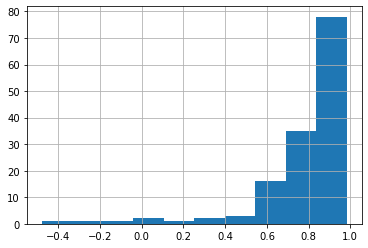

In [37]:
pd.Series(r_l).hist()

# alternatives for seperating disinhibition=> pop up and inhibition => pop up

## alternative 1: use pre pop up pyr activity, as in the switch metrics

In [ ]:
thresh=1.
metric_key = 'pre_ntrial_ge_30_perc_frac_total'
ma = all_sw_with_metrics_oneti_with_inh_change_onesw['inh_fr_change']<-thresh
xx=all_sw_with_metrics_oneti_with_inh_change_onesw.loc[ma,metric_key]
ax=xx.hist(label='disinhibition',alpha=0.5,density=True)

ma = all_sw_with_metrics_oneti_with_inh_change_onesw['inh_fr_change']>thresh
yy=all_sw_with_metrics_oneti_with_inh_change_onesw.loc[ma,metric_key]
ax=yy.hist(label='more inhibition',ax=ax,alpha=0.5,density=True)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel(metric_key)
ax.set_title(f'switch={sw}')

ph.plot_cdf_and_ks_test(xx,yy)
print(scipy.stats.ranksums(xx,yy))


## alternative 2:  aggregate pre pop up int activities

In [145]:
all_sw_with_metrics

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both   66            0  6684.468867    27.401026       25.0   
  1        both   67            0  6683.535300    30.506287        8.0   
  2        both  186            0  6684.402200    30.468344       24.0   
  3        both  329            0  6684.035433    40.542415       17.0   
  4        both  349            0  6684.035433    40.542415       17.0   
...         ...  ...          ...          ...          ...        ...   
  201       0.0  181            1  8222.942500    11.502441       43.0   
  202       0.0  204            0  8220.241800     8.558946       35.0   
  203       0.0  250            0  8242.805858    19.295595       83.0   
  204       0.0  313            1  8234.245367    15.980170       56.0   
  205       0.0  357            1  8223.709333    11.951551       49.0   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2     1.0             1           2.0  ...   
  1              2     1.0             1           2.0  ...   
  2              2     1.0             1           2.0  ...   
  3              2     1.0             1           2.0  ...   
  4              2     1.0             1           2.0  ...   
...            ...     ...           ...           ...  ...   
  201           30     1.0            18          18.0  ...   
  202           30     1.0            18          18.0  ...   
  203           30     1.0            18          18.0  ...   
  204           30     1.0            18          18.0  ...   
  205           30    -1.0            18          18.0  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                  0.0                            0.03125   
  1                                  0.0                            0.00000   
  2                                  0.0                            0.00000   
  3                                  0.0                            0.00000   
  4                                  0.0                            0.00000   
...                                  ...                                ...   
  201                                0.0                            0.00000   
  202                                0.0                            0.00000   
  203                                0.0                            0.00000   
  204                                0.0                            0.00000   
  205                                0.0                            0.10000   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.46875                            0.75000   
  1                              0.03125                            0.28125   
  2                              0.03125                            0.12500   
  3                              0.00000                            0.03125   
  4                              0.06250                            0.09375   
...                                  ...                                ...   
  201                            0.00000                            0.05000   
  202                            0.00000                            0.00000   
  203                            0.05000                            0.05000   
  204                            0.00000                            0.00000   
  205                            0.10000                            0.10000   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                               0.8750                            0.93750   
  1                               0.6250                            0.71875   
  2                               0.1875                            0.21875   
  3                               0.1250                            0.21875   
  4                               0.2500                           

In [165]:
all_sw_with_metrics

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both   66            0  6684.468867    27.401026       25.0   
  1        both   67            0  6683.535300    30.506287        8.0   
  2        both  186            0  6684.402200    30.468344       24.0   
  3        both  329            0  6684.035433    40.542415       17.0   
  4        both  349            0  6684.035433    40.542415       17.0   
...         ...  ...          ...          ...          ...        ...   
  201       0.0  181            1  8222.942500    11.502441       43.0   
  202       0.0  204            0  8220.241800     8.558946       35.0   
  203       0.0  250            0  8242.805858    19.295595       83.0   
  204       0.0  313            1  8234.245367    15.980170       56.0   
  205       0.0  357            1  8223.709333    11.951551       49.0   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2     1.0             1           2.0  ...   
  1              2     1.0             1           2.0  ...   
  2              2     1.0             1           2.0  ...   
  3              2     1.0             1           2.0  ...   
  4              2     1.0             1           2.0  ...   
...            ...     ...           ...           ...  ...   
  201           30     1.0            18          18.0  ...   
  202           30     1.0            18          18.0  ...   
  203           30     1.0            18          18.0  ...   
  204           30     1.0            18          18.0  ...   
  205           30    -1.0            18          18.0  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                  0.0                            0.03125   
  1                                  0.0                            0.00000   
  2                                  0.0                            0.00000   
  3                                  0.0                            0.00000   
  4                                  0.0                            0.00000   
...                                  ...                                ...   
  201                                0.0                            0.00000   
  202                                0.0                            0.00000   
  203                                0.0                            0.00000   
  204                                0.0                            0.00000   
  205                                0.0                            0.10000   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.46875                            0.75000   
  1                              0.03125                            0.28125   
  2                              0.03125                            0.12500   
  3                              0.00000                            0.03125   
  4                              0.06250                            0.09375   
...                                  ...                                ...   
  201                            0.00000                            0.05000   
  202                            0.00000                            0.00000   
  203                            0.05000                            0.05000   
  204                            0.00000                            0.00000   
  205                            0.10000                            0.10000   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                               0.8750                            0.93750   
  1                               0.6250                            0.71875   
  2                               0.1875                            0.21875   
  3                               0.1250                            0.21875   
  4                               0.2500                           

In [182]:
int_d = {}
data_all_sw = all_sw_with_metrics.query('switch==-1')

for k,row in data_all_sw.iterrows():
    ti = k[0]
    tt,uid,field_id,sw_tr=row[['trialtype','uid','field_index','switch_trial']]
    pre_int = mean_within_field_pred_all.loc[(tt,uid,field_id),:(sw_tr-1)].mean()
    post_int = mean_within_field_pred_all.loc[(tt,uid,field_id),(sw_tr+1):].mean()
    at_int = mean_within_field_pred_all.loc[(tt,uid,field_id),sw_tr].mean()
    around_int = mean_within_field_pred_all.loc[(tt,uid,field_id),(sw_tr-1):(sw_tr+1)].mean()
    int_d_one = {'pre_int':pre_int,'at_int':at_int,'around_int':around_int,'post_int':post_int}
    int_d[k] = pd.Series(int_d_one)
int_d = pd.concat(int_d,axis=0).unstack()
    

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Mean Selected Int. FR')]

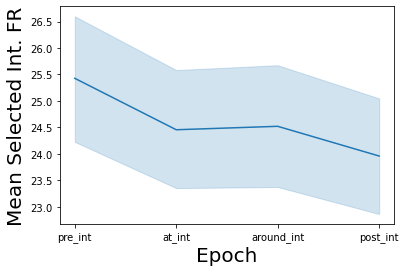

In [181]:
xtickslabels=int_d.columns
int_d.columns=[0,1,2,3]
ax=sns.lineplot(data=int_d.melt(),x='variable',y='value')
ax.set_xticks(int_d.columns)
ax.set_xticklabels(xtickslabels)
ax.set(xlabel='Epoch',ylabel='Mean Selected Int. FR')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Mean Selected Int. FR')]

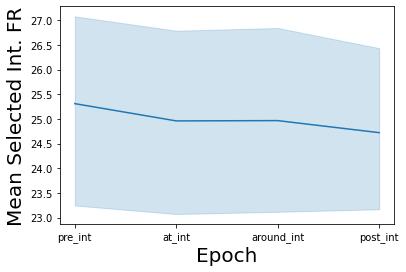

In [183]:
xtickslabels=int_d.columns
int_d.columns=[0,1,2,3]
ax=sns.lineplot(data=int_d.melt(),x='variable',y='value')
ax.set_xticks(int_d.columns)
ax.set_xticklabels(xtickslabels)
ax.set(xlabel='Epoch',ylabel='Mean Selected Int. FR')

In [155]:
around_int

26.089834101537207

In [151]:
mean_within_field_pred_all.loc[(tt,uid,field_id),:(sw_tr-1)]

0     25.883681
1     22.353731
2     23.467761
3     22.714072
4     22.629000
5     24.672508
6     22.062261
7     19.543929
8     24.353722
9     25.396237
10    24.984308
11    25.068810
12    25.379812
13    22.238351
14    24.846353
15    21.988556
16    21.110848
17    26.959944
Name: (0.0, 357, 1), dtype: float64

In [143]:
val

trialtype                                    0.0
uid                                          357
field_index                                    1
time                                 8223.709333
speed_gauss                            11.951551
                                        ...     
post_ntrial_ge_10_perc_frac_total            0.1
post_ntrial_ge_30_perc_frac_total            0.0
post_ntrial_ge_50_perc_frac_total            0.0
post_ntrial_ge_70_perc_frac_total            0.0
post_ntrial_ge_90_perc_frac_total            0.0
Name: (0, 205), Length: 89, dtype: object

In [142]:
val

trialtype                                    0.0
uid                                          357
field_index                                    1
time                                 8223.709333
speed_gauss                            11.951551
                                        ...     
post_ntrial_ge_10_perc_frac_total            0.1
post_ntrial_ge_30_perc_frac_total            0.0
post_ntrial_ge_50_perc_frac_total            0.0
post_ntrial_ge_70_perc_frac_total            0.0
post_ntrial_ge_90_perc_frac_total            0.0
Name: (0, 205), Length: 89, dtype: object

In [138]:
mean_within_field_pred_all

0          1          2          3          4          5   \
0.0  32  1  25.328166  23.419158  21.017857  20.384563  19.164543  21.092686   
     42  1  35.084427  32.444113  31.029054  33.121803  26.956797  30.025327   
         2  35.363154  32.477925  36.932409  27.555896  29.148177  29.599506   
     55  2  34.380064  34.530989  28.684081  42.800482  31.505681  35.717192   
     60  1  32.254180  38.326353  37.695466  37.790076  28.790593  37.718774   
...               ...        ...        ...        ...        ...        ...   
both 329 0  30.319905  27.387969  25.623506  25.817841  25.101422  23.534068   
     349 0  20.857812  21.404406  19.664371  16.886943  17.183900  14.027021   
     354 0  35.789418  35.671874  29.076411  32.313734  23.673763  26.333090   
     359 0  42.777884  44.692381  41.246522  35.924717  40.956408  34.037571   
     376 0  25.930914  26.449172  25.382795  19.527468  22.749873  19.685106   

                   6          7          8          9   ...         22  \
0.0  32  1  22.138354  18.563939  19.589717  22.064412  ...        NaN   
     42  1  28.255449  28.306306  24.575357  27.221637  ...        NaN   
         2  28.467148  28.026463  26.476226  33.988961  ...        NaN   
     55  2  34.147989  28.064945  27.923885  32.529496  ...        NaN   
     60  1  33.738280  36.055277  34.114583  36.666448  ...        NaN   
...               ...        ...        ...        ...  ...        ...   
both 329 0  23.806949  24.643253  24.464738  23.116864  ...  25.373187   
     349 0  16.348073  17.248317  15.980430  13.287461  ...  14.367362   
     354 0  25.487825  25.765937  24.371299  18.252553  ...  24.033161   
     359 0  36.368569  35.506743  36.186789  37.753735  ...  34.275372   
     376 0  20.018272  20.909546  20.506586  24.016781  ...  20.582345   

                   23         24         25         26         27         28  \
0.0  32  1        NaN        NaN        NaN        NaN        NaN        NaN   
     42  1        NaN        NaN        NaN        NaN        NaN        NaN   
         2        NaN        NaN        NaN        NaN        NaN        NaN   
     55  2        NaN        NaN        NaN        NaN        NaN        NaN   
     60  1        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
both 329 0  23.893841  25.479990  23.352165  23.494778  23.779368  21.277859   
     349 0  14.597404  17.052243  13.253888  11.861147  12.710794  12.206301   
     354 0  22.259040  29.008868  22.846001  20.976939  20.282615  18.642413   
     359 0  33.591739  37.123970  31.228210  28.634861  37.368042  32.725159   
     376 0  21.564281  23.224951  18.465181  19.429448  20.640796  24.594621   

                   29         30         31  
0.0  32  1        NaN        NaN        NaN  
     42  1        NaN        NaN        NaN  
         2        NaN        NaN        NaN  
     55  2        NaN        NaN        NaN  
     60  1        NaN        NaN        NaN  
...               ...        ...        ...  
both 329 0  22.828053  24.260991  23.283905  
     349 0  12.767136  14.479124  12.885547  
     354 0  19.891009  25.167731  20.090016  
     359 0  31.987403  32.296946  31.571056  
     376 0  19.442033  20.005925  19.976936  

[142 rows x 32 columns]

In [136]:
all_sw_with_metrics_oneti_with_inh_change_onesw

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change,fit_var_ratio,sparsity,mean
0,both,66,0,6684.468867,27.401026,25.0,2,1.0,1,2.0,...,0.8750,0.93750,0.90625,0.46875,0.18750,0.06250,-1.077994,0.710373,1.265996,15.441749
1,both,67,0,6683.535300,30.506287,8.0,2,1.0,1,2.0,...,0.6250,0.71875,0.71875,0.68750,0.43750,0.09375,-0.764157,0.542660,1.666003,19.180310
2,both,186,0,6684.402200,30.468344,24.0,2,1.0,1,2.0,...,0.1875,0.21875,0.21875,0.18750,0.09375,0.03125,-0.727079,0.695016,1.629435,4.521723
3,both,329,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.1250,0.21875,0.21875,0.21875,0.18750,0.09375,-1.764463,0.578723,2.015310,20.125519
4,both,349,0,6684.035433,40.542415,17.0,2,1.0,1,2.0,...,0.2500,0.31250,0.31250,0.25000,0.21875,0.06250,-1.740035,0.658906,2.851918,15.024616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,125,0,8219.524950,8.016434,34.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,-4.368691,0.766162,7.469497,3.916041
201,0.0,181,1,8222.942500,11.502441,43.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.05000,0.05000,1.796924,0.638267,2.280955,2.517687
202,0.0,204,0,8220.241800,8.558946,35.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.10000,0.10000,0.05000,0.320355,0.843652,4.206337,2.134234
203,0.0,250,0,8242.805858,19.295595,83.0,30,1.0,18,18.0,...,0.0500,0.10000,0.10000,0.05000,0.05000,0.05000,3.013733,0.789125,4.886189,2.604224
